In [1]:
import torch
TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.','')
print(TORCH, CUDA)

import pickle
import os

2.5.1 cu124


In [3]:
%%capture
!pip install pyg_lib -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-scatter     -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install torch-geometric

In [4]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm

from tqdm.auto import tqdm

import math
from numba import cuda
import numpy as np
import torch
from torch_geometric.utils import (
    to_networkx,
    from_networkx,
    to_dense_adj,
    remove_self_loops,
    to_undirected,
)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set up Functions

In [6]:
def data_to_kNN(X,k):
  edge_index = torch_geometric.nn.knn_graph(X, k)
  edge_index = to_undirected(edge_index, num_nodes=X.shape[0])
  return edge_index

def data_to_GNN_data(X,Y,k):
  dataset = []
  N = X.shape[0]
  for i in range(N):
    data = Data(x = X[i,:,:], y = Y[i,:,:], edge_index = data_to_kNN(X[i,:,:],k))
    data.num_nodes = 20
    data.num_edges = data.edge_index.shape[1]
    dataset.append(data)
  return dataset

def data_to_GNN_data_fm(X,Y,k):
  dataset = []
  N = len(X)
  for i in tqdm(range(N)):
    data = Data(x = X[i], y = Y[i], edge_index = data_to_kNN(X[i],k))
    data.num_nodes = X[i].shape[0]
    data.num_edges = data.edge_index.shape[1]
    dataset.append(data)
  return dataset

# Define the Models

In [7]:
import torch
import scipy.io as sio
import torch.nn as nn

In [8]:
# Throughout this we are going to assume that data is of the form B x N x D
# Where B is the batch size, N is the sequence length for the transformer
# this the number of data points. Finally D is the embedding dimension.
class SimpleAttention(nn.Module):
  # Initialize the parameter
  def __init__(self, hidden_dim):
    super(SimpleAttention, self).__init__()
    self.linear = nn.Linear(hidden_dim, hidden_dim)
    self.WQ = nn.Linear(hidden_dim, hidden_dim, bias = False)
    self.WK = nn.Linear(hidden_dim, hidden_dim, bias = False)
    self.WV = nn.Linear(hidden_dim, hidden_dim, bias = False)
    self.skip = nn.Linear(hidden_dim, hidden_dim)
    self.attention = nn.MultiheadAttention(hidden_dim, 1, batch_first=True)

  # Forward pass
  def forward(self, input):
    Q = self.WQ(input)
    K = self.WK(input)
    V = self.WV(input)
    output_attention,_ = self.attention(Q,K,V)
    output_linear = self.linear(output_attention.relu()).relu()
    return output_linear + self.skip(input)

class SimpleTransformer(nn.Module):
# Initialize the parameter
  def __init__(self, input_dim, hidden_dim, out_dim, num_layers):
    super(SimpleTransformer, self).__init__()
    self.embed = nn.Linear(input_dim, hidden_dim)
    self.predictor = nn.Linear(hidden_dim, out_dim)
    self.AttentionLayers = []
    for i in range(num_layers):
      self.AttentionLayers.append(SimpleAttention(hidden_dim))

    self.AttentionLayers = nn.ModuleList(self.AttentionLayers)
    self.num_layers = num_layers

  # Forward pass
  def forward(self, z):
    z = self.embed(z)
    for i in range(self.num_layers):
      z = self.AttentionLayers[i](z)
    return self.predictor(z)


class FNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, out_dim, num_layers, d):
    super(FNN, self).__init__()
    self.embed = nn.Linear(input_dim, hidden_dim)
    self.predictor = nn.Linear(hidden_dim, out_dim)
    self.Layers = []
    for i in range(num_layers):
      self.Layers.append(nn.Linear(hidden_dim, hidden_dim))

    self.Layers = nn.ModuleList(self.Layers)
    self.num_layers = num_layers
    self.d = d

  # Input size B x N X 4
  def forward(self,x):
    x = torch.flatten(x, 1, 2) # B x N4
    x = self.embed(x).relu()
    for i in range(self.num_layers):
      x = self.Layers[i](x).relu()
    x = self.predictor(x)
    x = torch.unflatten(x, 1, (-1,self.d))
    return x

def kernel_basis(X, d1, d2):
  N = X.shape[0]
  d = X.shape[1]

  Phi = torch.zeros(N, (d1+2*d2)*d, device = X.device)
  for i in range(d1+2*d2):
    if i < d1:
      for j in range(d):
        Phi[:,d*i+j] = X[:,j].pow(i+1)
    elif i < d1+d2:
      for j in range(d):
        k = i-d1+1
        Phi[:,d*i+j] = (X[:,j]*k).sin()
    else:
      for j in range(d):
        k = i-d1-d2+1
        Phi[:,d*i+j] = torch.cos(X[:,j]*k)

  return Phi

class Kernel(nn.Module):
  def __init__(self, feature_dim, out_dim, d, embed=kernel_basis):
    super(Kernel, self).__init__()
    self.predictor = nn.Linear(feature_dim, out_dim, device = "cuda")
    self.embed = embed
    self.d = d

  # Input size B x N X 4
  def forward(self,x):
    x = self.predictor(x)
    x = torch.unflatten(x, 1, (-1,self.d))
    return x


In [9]:
def get_nn(in_channels, out_channels):
  return torch.nn.Sequential(torch.nn.Linear(in_channels, out_channels), torch.nn.ReLU(),
                             torch.nn.Linear(out_channels, out_channels))

class GNN(torch.nn.Module):
  def __init__(self, node_input_dim, output_dim, num_layers, hidden_dim = 128, device = "cuda", arch = "Graph"):
    super().__init__()

    self.num_layers = num_layers
    self.layers = []
    if arch == "Transformer":
      self.layers.append(torch_geometric.nn.TransformerConv(node_input_dim, hidden_dim).to(device))
      for i in range(num_layers-1):
        self.layers.append(torch_geometric.nn.TransformerConv(hidden_dim, hidden_dim).to(device))
    elif arch == "Graph":
      self.layers.append(torch_geometric.nn.GraphConv(node_input_dim, hidden_dim).to(device))
      for i in range(num_layers-1):
        self.layers.append(torch_geometric.nn.GraphConv(hidden_dim, hidden_dim).to(device))
    elif arch == "GIN":
      self.layers.append(torch_geometric.nn.GINConv(get_nn(node_input_dim, hidden_dim)).to(device))
      for i in range(num_layers-1):
        self.layers.append(torch_geometric.nn.GINConv(get_nn(hidden_dim, hidden_dim)).to(device))

    self.layers = torch.nn.ModuleList(self.layers)
    self.lin = torch.nn.Linear(hidden_dim, output_dim).to(device)

  def forward(self, x, edge_index, batch):
    for i in range(self.num_layers):
      x = self.layers[i](x, edge_index).relu()

    z = self.lin(x)
    return z

# Code for Simulating

In [10]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import torch

# def CS_slow(t,z,N):

#   dxdt = np.zeros(N); dydt = np.zeros(N)
#   dudt = np.zeros(N); dvdt = np.zeros(N)

#   x = z[0,:]; y = z[1,:]
#   u = z[2,:]; v = z[3,:]

#   Fx = np.zeros((N,N)); Fy = np.zeros((N,N))

#   for i in range(0,N):
#     for j in range(0,N):
#         Fx[i,j] = (1/N)*Phi(np.linalg.norm(np.array([x[i]-x[j], y[i]-y[j]])))*(u[j]-u[i])
#         Fy[i,j] = (1/N)*Phi(np.linalg.norm(np.array([x[i]-x[j], y[i]-y[j]])))*(v[j]-v[i])

#   for i in range(0,N):
#     dxdt[i] = u[i]
#     dydt[i] = v[i]
#     dudt[i] = np.sum(Fx[i,:])
#     dvdt[i] = np.sum(Fy[i,:])

#   return dxdt, dydt, dudt, dvdt


def CS(t,z,N):

  dxdt = torch.zeros(N); dydt = torch.zeros(N)
  dudt = torch.zeros(N); dvdt = torch.zeros(N)

  x = z[0,:]; y = z[1,:]
  u = z[2,:]; v = z[3,:]

  X = z[:2,:].T
  d = torch.cdist(X,X)

  Phi_X = 1/(1 + d.square())
  udiff = u.view(-1,1) - u.view(1,-1)
  vdiff = v.view(-1,1) - v.view(1,-1)

  Fx = -1 * Phi_X * udiff/N
  Fy = -1 * Phi_X * vdiff/N

  for i in range(0,N):
    dxdt[i] = u[i]
    dydt[i] = v[i]
    dudt[i] = Fx[i,:].sum()
    dvdt[i] = Fy[i,:].sum()

  return dxdt, dydt, dudt, dvdt

def Phi(r):
   H = 1; s = 1; b = 1
   y = H/(s**2+r**2)**b
   return y

# %%%%%%%%%%%%%%%%%%%%%%% Main %%%%%%%%%%%%%%%%%%%%%%%

N = 20 # Number of agents
T = 100 # Final time

x0 = np.random.uniform(0,1,N)
y0 = np.random.uniform(0,1,N)
u0 = np.random.uniform(0,1,N)
v0 = np.random.uniform(0,1,N)
z0 = np.concatenate((x0,y0,u0,v0))

t_eval = torch.tensor(range(0,500))*T/500

## For Other Models

In [11]:
def resize_tensor(A):
  N, T = A.shape
  n = N//4
  new_A = torch.zeros(T, N//4, 4)

  new_A[:,:,0] = A.T[:,:n]
  new_A[:,:,1] = A.T[:,n:2*n]
  new_A[:,:,2] = A.T[:,2*n:3*n]
  new_A[:,:,3] = A.T[:,3*n:]

  return new_A

In [12]:
def CS_Transformer(t,z,N):

  z = torch.tensor(z).unsqueeze(-1)

  x = resize_tensor(z).to('cuda')
  y = model(x)[0,:]
  out = torch.cat((y[:,0],y[:,1],y[:,2],y[:,3]), dim=0)

  return out.cpu().detach().numpy()

In [13]:
model = torch.load("drive/MyDrive/MeasureMaps/Transformer/trial-0-depth-5-width-256-lr-0.0002-epoch-1000.pt")
model.eval()

<ipython-input-13-41896678913d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("drive/MyDrive/MeasureMaps/Transformer/trial-0-depth-5-width-256-lr-0.000

SimpleTransformer(
  (embed): Linear(in_features=4, out_features=256, bias=True)
  (predictor): Linear(in_features=256, out_features=4, bias=True)
  (AttentionLayers): ModuleList(
    (0-4): 5 x SimpleAttention(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (WQ): Linear(in_features=256, out_features=256, bias=False)
      (WK): Linear(in_features=256, out_features=256, bias=False)
      (WV): Linear(in_features=256, out_features=256, bias=False)
      (skip): Linear(in_features=256, out_features=256, bias=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
    )
  )
)

In [14]:
def compute_F(z0, N=10000):
  z = torch.zeros((4,N))
  z[:,0] = z0
  z[:,1:] = torch.rand(4,N-1)
  dx, dy, du, dv = CS(0, z, N)
  return torch.tensor([dx[0].item(), dy[0].item(), du[0].item(), dv[0].item()])

In [15]:
def expected_T(z0, n = 20, N = 10000):
  z0 = z0.to('cuda')
  z = torch.zeros(N,n,4, device = 'cuda')
  z[:,0,:] = z0.view(1,-1)
  z[:,1:,:] = torch.rand(N,n-1,4)
  y = model(z).mean(dim =0)
  return y[0,:].cpu().detach()

In [16]:
def create_mesh(N):
    x = np.linspace(0, 1, N)
    X1, X2, X3, X4 = np.meshgrid(x, x, x, x, indexing='ij')
    mesh_points = np.vstack([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel()]).T
    return torch.tensor(mesh_points)

# Example usage:
N = 3
mesh = create_mesh(N)
print(mesh)
print("Mesh shape:", mesh.shape)  # Should be (N^4, 4)

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.5000],
        [0.0000, 0.0000, 0.5000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.5000],
        [0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000, 0.5000],
        [0.0000, 0.5000, 0.0000, 1.0000],
        [0.0000, 0.5000, 0.5000, 0.0000],
        [0.0000, 0.5000, 0.5000, 0.5000],
        [0.0000, 0.5000, 0.5000, 1.0000],
        [0.0000, 0.5000, 1.0000, 0.0000],
        [0.0000, 0.5000, 1.0000, 0.5000],
        [0.0000, 0.5000, 1.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.5000],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.5000, 0.0000],
        [0.0000, 1.0000, 0.5000, 0.5000],
        [0.0000, 1.0000, 0.5000, 1

In [17]:
def compute_errors_on_grid(mesh, n=20):
  N = mesh.shape[0]
  errors = torch.zeros(N)
  for i in tqdm(range(N)):
    z0 = mesh[i,:]
    dz_theory = compute_F(z0)
    dz = expected_T(z0, n = 20)
    errors[i] = ((dz-dz_theory)).abs().max()
  return errors

In [ ]:
errors = compute_errors_on_grid(mesh)

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
errors[:125].mean()

tensor(0.0132)

In [ ]:
errors[125:250].mean()

tensor(0.0186)

In [ ]:
errors[250:375].mean()

tensor(0.0197)

In [ ]:
errors[250:275].mean()

tensor(0.0143)

In [ ]:
errors[275:300].mean()

tensor(0.0225)

In [ ]:
errors[300:325].mean()

tensor(0.0246)

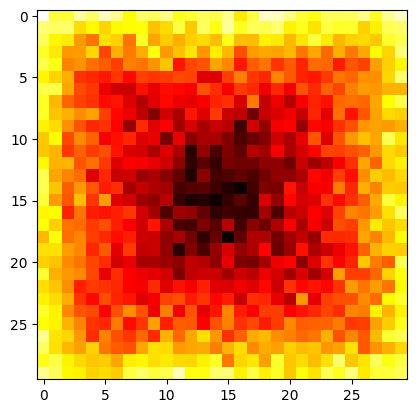

In [ ]:
plt.imshow(errors.reshape(5,5), cmap="hot")

In [ ]:
errors[325:350].mean()

tensor(0.0223)

In [ ]:
errors[350:375].mean()

tensor(0.0148)

In [ ]:
errors[375:500].mean()

tensor(0.0195)

In [ ]:
errors[500:625].mean()

tensor(0.0144)

In [ ]:
def errors_over_seqeunce_length(mesh, ns):
  errors = torch.zeros(len(ns))
  idx = 0
  for n in ns:
    errors[idx] = compute_errors_on_grid(mesh, n=n).max()
    print(errors[idx])
    idx += 1
  return errors

In [ ]:
errors_over_seqeunce_length(mesh, [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0383)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0378)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0382)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0363)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0382)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0363)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0393)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0386)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0366)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0344)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0378)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0373)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0364)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0382)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0381)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0350)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0372)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0363)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0360)


  0%|          | 0/81 [00:00<?, ?it/s]

tensor(0.0384)


tensor([0.0383, 0.0378, 0.0382, 0.0363, 0.0382, 0.0363, 0.0393, 0.0386, 0.0366,
        0.0344, 0.0378, 0.0373, 0.0364, 0.0382, 0.0381, 0.0350, 0.0372, 0.0363,
        0.0360, 0.0384])